# Agricultural Data Analysis for ML

This notebook demonstrates how **multi-spectral agricultural data can be analyzed and prepared for machine learning applications**. The focus is on building reliable data foundations, ensuring quality, and extracting insights that can inform downstream ML tasks. Our work spans five key pillars:

- **Multi-spectral Data Handling** – Processing RGB + NDVI imagery and NPZ datasets  
- **Data Quality & Validation** – Thresholding, error checks, and agricultural-specific QA  
- **Analysis Workflows** – Structured steps for preparing multi-crop datasets  
- **Visualization & Reporting** – Turning complex data into clear, interpretable outputs  
- **Domain Relevance** – Applications to crop health and precision agriculture scenarios  

## Technical Objectives

By the end of this notebook, you will see:

1. **Data Engineering** – Loading, validating, and structuring multi-spectral datasets  
2. **Quality Assurance** – Applying domain-specific checks for agricultural data reliability  
3. **Exploratory Analysis** – Multi-modal metrics and crop-level comparisons  
4. **Visualization & Insights** – Data-driven reporting for stakeholders  
5. **Real-World Relevance** – Demonstrating how analysis supports precision agriculture ML pipelines  

## Environment Setup

First, let's set up our environment and import the necessary modules for multi-spectral agricultural data processing.

In [11]:
# Standard scientific computing imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Configure plotting for professional presentation
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

# Add project root to path for custom module imports
import sys
sys.path.append('..')  # Go up one level from notebooks/ to project root

# Import custom agricultural data processing modules
from src.multi_spectral_processing.data_validation import validate_multi_spectral_dataset
from src.multi_spectral_processing.cloud_analysis import analyze_cloud_coverage
from src.multi_spectral_processing.data_inspection import inspect_npz_file, summarize_npz_file
from src.agricultural_data.crop_data_processing import AgriculturalDataProcessor
from src.agricultural_data.data_quality_assurance import AgriculturalDataQualityAssurance
from src.agricultural_data.multi_modal_analysis import MultiModalAgriculturalAnalyzer

# Import example utilities for demonstration
from examples.npz_data_loading_example import (
    load_agricultural_npz_dataset, 
    process_multi_spectral_data,
    visualize_agricultural_data
)

print("✓ All modules imported successfully!")
print(f"Working directory: {Path.cwd()}")

✓ All modules imported successfully!
Working directory: /Users/caroline/Desktop/Agricultural_ML_Showcase/notebooks


## Part 1: Multi-Spectral Data Loading and Validation

Let's start by demonstrating how to load and validate multi-spectral agricultural datasets using our custom tools.

In [46]:
# Load all available crop datasets
print("Loading multi-crop agricultural datasets...")

crop_datasets = {}
crop_names = ['corn', 'soybean', 'wheat', 'rice']
data_dir = Path("../data/processed/subset_75_all_npz")

for crop_name in crop_names:
    crop_path = data_dir / f"{crop_name}_subset.npz"
    if crop_path.exists():
        print(f"Loading {crop_name} dataset...")
        crop_datasets[crop_name] = load_agricultural_npz_dataset(str(crop_path))
        print(f"  ✓ {crop_name}: {crop_datasets[crop_name]['rgb'].shape[0]} images")
    else:
        print(f"  ✗ {crop_name} dataset not found at: {crop_path}")

print(f"\nSuccessfully loaded {len(crop_datasets)} crop datasets")

# Display overview of all loaded datasets
print(f"\nDataset Overview:")
for crop_name, dataset in crop_datasets.items():
    print(f"\n{crop_name.upper()}:")
    for key, data in dataset.items():
        print(f"  {key}: {data.shape}, {data.dtype}, {data.nbytes / (1024*1024):.2f} MB")

Loading multi-crop agricultural datasets...
Loading corn dataset...
Loading agricultural dataset: ../data/processed/subset_75_all_npz/corn_subset.npz
Dataset loaded in 0.001 seconds
Available data keys: ['ndvi', 'rgb', 'cloud_mask', 'patch_ids']
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB
  ✓ corn: 75 images
Loading soybean dataset...
Loading agricultural dataset: ../data/processed/subset_75_all_npz/soybean_subset.npz
Dataset loaded in 0.000 seconds
Available data keys: ['ndvi', 'rgb', 'cloud_mask', 'patch_ids']
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB
  ✓ soybean: 75 images
Loading wheat dataset...
Loading agricultural dataset: ../data/processed/subset_75_all_npz/wheat_subset.npz
Dataset loaded in 0.001 seconds
Available data keys: ['ndvi', 'rgb', 'cloud_m

In [49]:
# Display overview of all loaded crop datasets
print("\nMulti-Crop Dataset Overview:")
for crop_name, dataset in crop_datasets.items():
    print(f"\n{crop_name.upper()}:")
    for key, data in dataset.items():
        print(f"  {key}: {data.shape}, {data.dtype}, {data.nbytes / (1024*1024):.2f} MB")


Multi-Crop Dataset Overview:

CORN:
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB

SOYBEAN:
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB

WHEAT:
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB

RICE:
  ndvi: (75, 64, 64), float32, 1.17 MB
  rgb: (75, 3, 64, 64), float32, 3.52 MB
  cloud_mask: (75, 64, 64), float32, 1.17 MB
  patch_ids: (75,), <U15, 0.00 MB


In [51]:
# Process multi-spectral data for all crops
print("Processing multi-spectral data for all crops...")

all_crop_statistics = {}
for crop_name, dataset in crop_datasets.items():
    print(f"\nProcessing {crop_name} dataset...")
    processed_data, statistics = process_multi_spectral_data(dataset)
    all_crop_statistics[crop_name] = statistics
    print(f"  ✓ {crop_name} processing complete")

print("\nMulti-Crop Data Statistics Summary:")
for crop_name, statistics in all_crop_statistics.items():
    print(f"\n{crop_name.upper()}:")
    for modality, stats in statistics.items():
        print(f"  {modality.upper()}:")
        for key, value in stats.items():
            if isinstance(value, float):
                print(f"    {key}: {value:.4f}")
            else:
                print(f"    {key}: {value}")

Processing multi-spectral data for all crops...

Processing corn dataset...

Processing multi-spectral data...
Processing RGB data: (75, 3, 64, 64)
  RGB Statistics:
    Red: mean=-0.151, std=14.433
    Green: mean=-0.139, std=14.433
    Blue: mean=-0.160, std=14.433
Processing NDVI data: (75, 64, 64)
  NDVI Statistics:
    Range: [-1000.000, 0.948]
    High vegetation (>0.6): 304,113
    Moderate vegetation (0.2-0.6): 3,023
    Low vegetation (0-0.2): 0
Processing cloud mask: (75, 64, 64)
  Cloud Statistics:
    Coverage: 0.02%
    Clear pixels: 307,136
    Cloudy pixels: 64
  ✓ corn processing complete

Processing soybean dataset...

Processing multi-spectral data...
Processing RGB data: (75, 3, 64, 64)
  RGB Statistics:
    Red: mean=-3.473, std=59.411
    Green: mean=-3.461, std=59.411
    Blue: mean=-3.484, std=59.410
Processing NDVI data: (75, 64, 64)
  NDVI Statistics:
    Range: [-1000.000, 0.960]
    High vegetation (>0.6): 302,201
    Moderate vegetation (0.2-0.6): 3,911
    

## Part 2: Data Validation and Quality Assurance

Now let's demonstrate our data validation capabilities, which are crucial for agricultural ML applications. We'll validate the multi-spectral dataset structure, check data quality metrics, and identify any potential issues that could affect model performance.

**Note:** This dataset has been pre-filtered for low cloud coverage (0.02%) for demonstration purposes. In real-world agricultural applications, cloud coverage typically ranges from 10-40%, requiring more sophisticated cloud masking and atmospheric correction techniques.

In [52]:
# Validate all multi-spectral crop datasets
print("Validating multi-spectral datasets for all crops...")

all_validation_results = {}
for crop_name, dataset in crop_datasets.items():
    print(f"\nValidating {crop_name} dataset...")
    # Get the file path for validation
    crop_path = data_dir / f"{crop_name}_subset.npz"
    validation_results = validate_multi_spectral_dataset(str(crop_path))
    all_validation_results[crop_name] = validation_results
    
    print(f"  Overall Valid: {validation_results.get('valid', 'Unknown')}")
    print(f"  Total Issues: {len(validation_results.get('issues', []))}")
    print(f"  Total Warnings: {len(validation_results.get('warnings', []))}")

# Display comprehensive validation summary
print(f"\n" + "="*50)
print("COMPREHENSIVE VALIDATION SUMMARY")
print("="*50)

for crop_name, validation_results in all_validation_results.items():
    print(f"\n{crop_name.upper()} VALIDATION RESULTS:")
    print(f"  Overall Valid: {validation_results.get('valid', 'Unknown')}")
    print(f"  Total Issues: {len(validation_results.get('issues', []))}")
    print(f"  Total Warnings: {len(validation_results.get('warnings', []))}")
    
    if validation_results.get('issues'):
        print("  Issues Found:")
        for issue in validation_results['issues']:
            print(f"    - {issue}")
    
    if validation_results.get('warnings'):
        print("  Warnings:")
        for warning in validation_results['warnings']:
            if "NDVI values outside expected range [-1,1]" in warning:
                print(f"    - NDVI range includes cloud masking values (negative values are masked)")
            else:
                print(f"    - {warning}")
    
    # Display additional validation details
    print("  Validation Details:")
    for key, value in validation_results.items():
        if key not in ['valid', 'issues', 'warnings', 'modalities']:
            if isinstance(value, float):
                print(f"    {key}: {value:.4f}")
            else:
                print(f"    {key}: {value}")

Validating multi-spectral datasets for all crops...

Validating corn dataset...
  Overall Valid: True
  Total Issues: 0
  Total Warnings: 2

Validating soybean dataset...
  Overall Valid: True
  Total Issues: 0
  Total Warnings: 2

Validating wheat dataset...
  Overall Valid: True
  Total Issues: 0
  Total Warnings: 2

Validating rice dataset...
  Overall Valid: True
  Total Issues: 0
  Total Warnings: 2

COMPREHENSIVE VALIDATION SUMMARY

CORN VALIDATION RESULTS:
  Overall Valid: True
  Total Issues: 0
  Total Warnings: 2
  Warnings:
    - NDVI range includes cloud masking values (negative values are masked)
    - Very low cloud coverage: 0.0%
  Validation Details:
    file_path: ../data/processed/subset_75_all_npz/corn_subset.npz
    overall_score: 9.0000
    component_validation: {'rgb': {'valid': True, 'issues': [], 'warnings': [], 'stats': {'sentinel_count': 192, 'total_pixels': 921600, 'min_value': 0.0, 'max_value': 0.5455999970436096, 'shape': '(75, 3, 64, 64)', 'dtype': 'float32

In [54]:
# Analyze cloud coverage for all crop datasets
print("Analyzing cloud coverage across all crops...")

all_cloud_stats = {}
for crop_name, dataset in crop_datasets.items():
    print(f"\nAnalyzing cloud coverage for {crop_name}...")
    crop_path = data_dir / f"{crop_name}_subset.npz"
    cloud_stats = analyze_cloud_coverage(str(crop_path))
    all_cloud_stats[crop_name] = cloud_stats

# Display comprehensive cloud coverage summary
print(f"\n" + "="*60)
print("COMPREHENSIVE CLOUD COVERAGE ANALYSIS")
print("="*60)

for crop_name, cloud_stats in all_cloud_stats.items():
    print(f"\n{crop_name.upper()} CLOUD COVERAGE:")
    print(f"  Overall Cloud Coverage: {cloud_stats['cloud_percentage']:.2f}%")
    print(f"  Clear Coverage: {cloud_stats['clear_percentage']:.2f}%")
    print(f"  Total Images: {cloud_stats['data_shape'][0]}")
    print(f"  Image Resolution: {cloud_stats['data_shape'][1]}x{cloud_stats['data_shape'][2]} pixels")
    
    # Display quality assessment
    quality = cloud_stats['quality_assessment']
    print(f"  Quality Level: {quality['quality_level']}")
    print(f"  Quality Score: {quality['quality_score']}/10")
    print(f"  Recommendation: {quality['recommendation']}")
    
    # Display coverage statistics
    coverage_stats = cloud_stats['coverage_statistics']
    print(f"  Mean Cloud Coverage: {coverage_stats['mean_coverage']:.4f}")
    print(f"  Max Cloud Coverage: {coverage_stats['max_coverage']:.4f}")
    print(f"  Coverage Std Dev: {coverage_stats['std_coverage']:.4f}")

# Compare cloud coverage across crops
print(f"\n" + "="*40)
print("CROSS-CROP CLOUD COVERAGE COMPARISON")
print("="*40)

cloud_percentages = {crop: stats['cloud_percentage'] for crop, stats in all_cloud_stats.items()}
quality_scores = {crop: stats['quality_assessment']['quality_score'] for crop, stats in all_cloud_stats.items()}

print(f"Cloud Coverage Ranking (Lowest to Highest):")
for crop, coverage in sorted(cloud_percentages.items(), key=lambda x: x[1]):
    print(f"  {crop.capitalize()}: {coverage:.2f}%")

print(f"\nQuality Score Ranking (Highest to Lowest):")
for crop, score in sorted(quality_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {crop.capitalize()}: {score}/10")

Analyzing cloud coverage across all crops...

Analyzing cloud coverage for corn...

Analyzing cloud coverage for soybean...

Analyzing cloud coverage for wheat...

Analyzing cloud coverage for rice...

COMPREHENSIVE CLOUD COVERAGE ANALYSIS

CORN CLOUD COVERAGE:
  Overall Cloud Coverage: 0.02%
  Clear Coverage: 99.98%
  Total Images: 75
  Image Resolution: 64x64 pixels
  Quality Level: Excellent
  Quality Score: 10/10
  Recommendation: Ideal for agricultural analysis and ML training
  Mean Cloud Coverage: 0.0002
  Max Cloud Coverage: 0.0156
  Coverage Std Dev: 0.0018

SOYBEAN CLOUD COVERAGE:
  Overall Cloud Coverage: 0.35%
  Clear Coverage: 99.65%
  Total Images: 75
  Image Resolution: 64x64 pixels
  Quality Level: Excellent
  Quality Score: 10/10
  Recommendation: Ideal for agricultural analysis and ML training
  Mean Cloud Coverage: 0.0035
  Max Cloud Coverage: 0.2656
  Coverage Std Dev: 0.0305

WHEAT CLOUD COVERAGE:
  Overall Cloud Coverage: 1.15%
  Clear Coverage: 98.85%
  Total Ima

## Part 3: Multi-Modal Analysis

Let's demonstrate our multi-modal analysis capabilities for combining RGB and NDVI data. This analysis will show how different spectral bands relate to vegetation health and help identify data quality patterns that are crucial for agricultural ML applications.

**Key Insights from Analysis:**
[WIP]

In [55]:
# Initialize multi-modal analyzer
print("Initializing Multi-Modal Agricultural Analyzer...")
analyzer = MultiModalAgriculturalAnalyzer()

# Analyze all crops
all_crop_analyses = {}
print("\nAnalyzing multi-modal data for all crops...")

for crop_name, dataset in crop_datasets.items():
    print(f"\nAnalyzing {crop_name} dataset...")
    
    # Analyze RGB data
    print(f"  Analyzing RGB imagery...")
    rgb_analysis = analyzer.analyze_rgb_data(dataset['rgb'])
    
    # Analyze NDVI data
    print(f"  Analyzing NDVI imagery...")
    ndvi_analysis = analyzer.analyze_ndvi_data(dataset['ndvi'])
    
    # Analyze multi-modal correlations
    print(f"  Analyzing RGB-NDVI correlations...")
    correlation_analysis = analyzer.analyze_multi_modal_correlation(dataset['rgb'], dataset['ndvi'])
    
    # Store all analyses
    all_crop_analyses[crop_name] = {
        'rgb': rgb_analysis,
        'ndvi': ndvi_analysis,
        'correlation': correlation_analysis
    }

# Display comprehensive multi-crop results
print(f"\n" + "="*60)
print("COMPREHENSIVE MULTI-CROP ANALYSIS RESULTS")
print("="*60)

for crop_name, analyses in all_crop_analyses.items():
    print(f"\n{crop_name.upper()} ANALYSIS:")
    print(f"  RGB Quality Score: {analyses['rgb'].get('quality_score', 'N/A')}/10")
    print(f"  NDVI Quality Score: {analyses['ndvi'].get('quality_score', 'N/A')}/10")
    
    if 'overall_correlation' in analyses['correlation']:
        corr_stats = analyses['correlation']['overall_correlation']
        print(f"  RGB-NDVI Correlation: {corr_stats['mean']:.4f} ± {corr_stats['std']:.4f}")

# Generate comprehensive multi-crop report
print(f"\nGenerating comprehensive multi-crop report...")
print("="*60)

for crop_name, analyses in all_crop_analyses.items():
    print(f"\n{crop_name.upper()} COMPREHENSIVE REPORT:")
    print("-" * 40)
    report = analyzer.generate_multi_modal_report(
        analyses['rgb'], 
        analyses['ndvi'], 
        analyses['correlation']
    )
    print(report)

# Cross-crop comparison summary
print(f"\n" + "="*60)
print("CROSS-CROP COMPARISON SUMMARY")
print("="*60)

# Compare quality scores across crops
rgb_scores = {crop: analyses['rgb'].get('quality_score', 0) for crop, analyses in all_crop_analyses.items()}
ndvi_scores = {crop: analyses['ndvi'].get('quality_score', 0) for crop, analyses in all_crop_analyses.items()}

print(f"RGB Quality Ranking (Highest to Lowest):")
for crop, score in sorted(rgb_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {crop.capitalize()}: {score}/10")

print(f"\nNDVI Quality Ranking (Highest to Lowest):")
for crop, score in sorted(ndvi_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {crop.capitalize()}: {score}/10")

Initializing Multi-Modal Agricultural Analyzer...

Analyzing multi-modal data for all crops...

Analyzing corn dataset...
  Analyzing RGB imagery...
Analyzing RGB agricultural imagery...
RGB analysis completed for 75 images (64x64)
  Analyzing NDVI imagery...
Analyzing NDVI agricultural imagery...
NDVI analysis completed for 75 images (64x64)
  Analyzing RGB-NDVI correlations...
Analyzing RGB-NDVI correlations...
Correlation analysis completed for 75 images

Analyzing soybean dataset...
  Analyzing RGB imagery...
Analyzing RGB agricultural imagery...
RGB analysis completed for 75 images (64x64)
  Analyzing NDVI imagery...
Analyzing NDVI agricultural imagery...
NDVI analysis completed for 75 images (64x64)
  Analyzing RGB-NDVI correlations...
Analyzing RGB-NDVI correlations...
Correlation analysis completed for 75 images

Analyzing wheat dataset...
  Analyzing RGB imagery...
Analyzing RGB agricultural imagery...
RGB analysis completed for 75 images (64x64)
  Analyzing NDVI imagery...
An

## Part 4: Data Visualization and Insights

Let's create comprehensive visualizations to understand our agricultural data better.

Creating comprehensive multi-crop agricultural analysis dashboard...


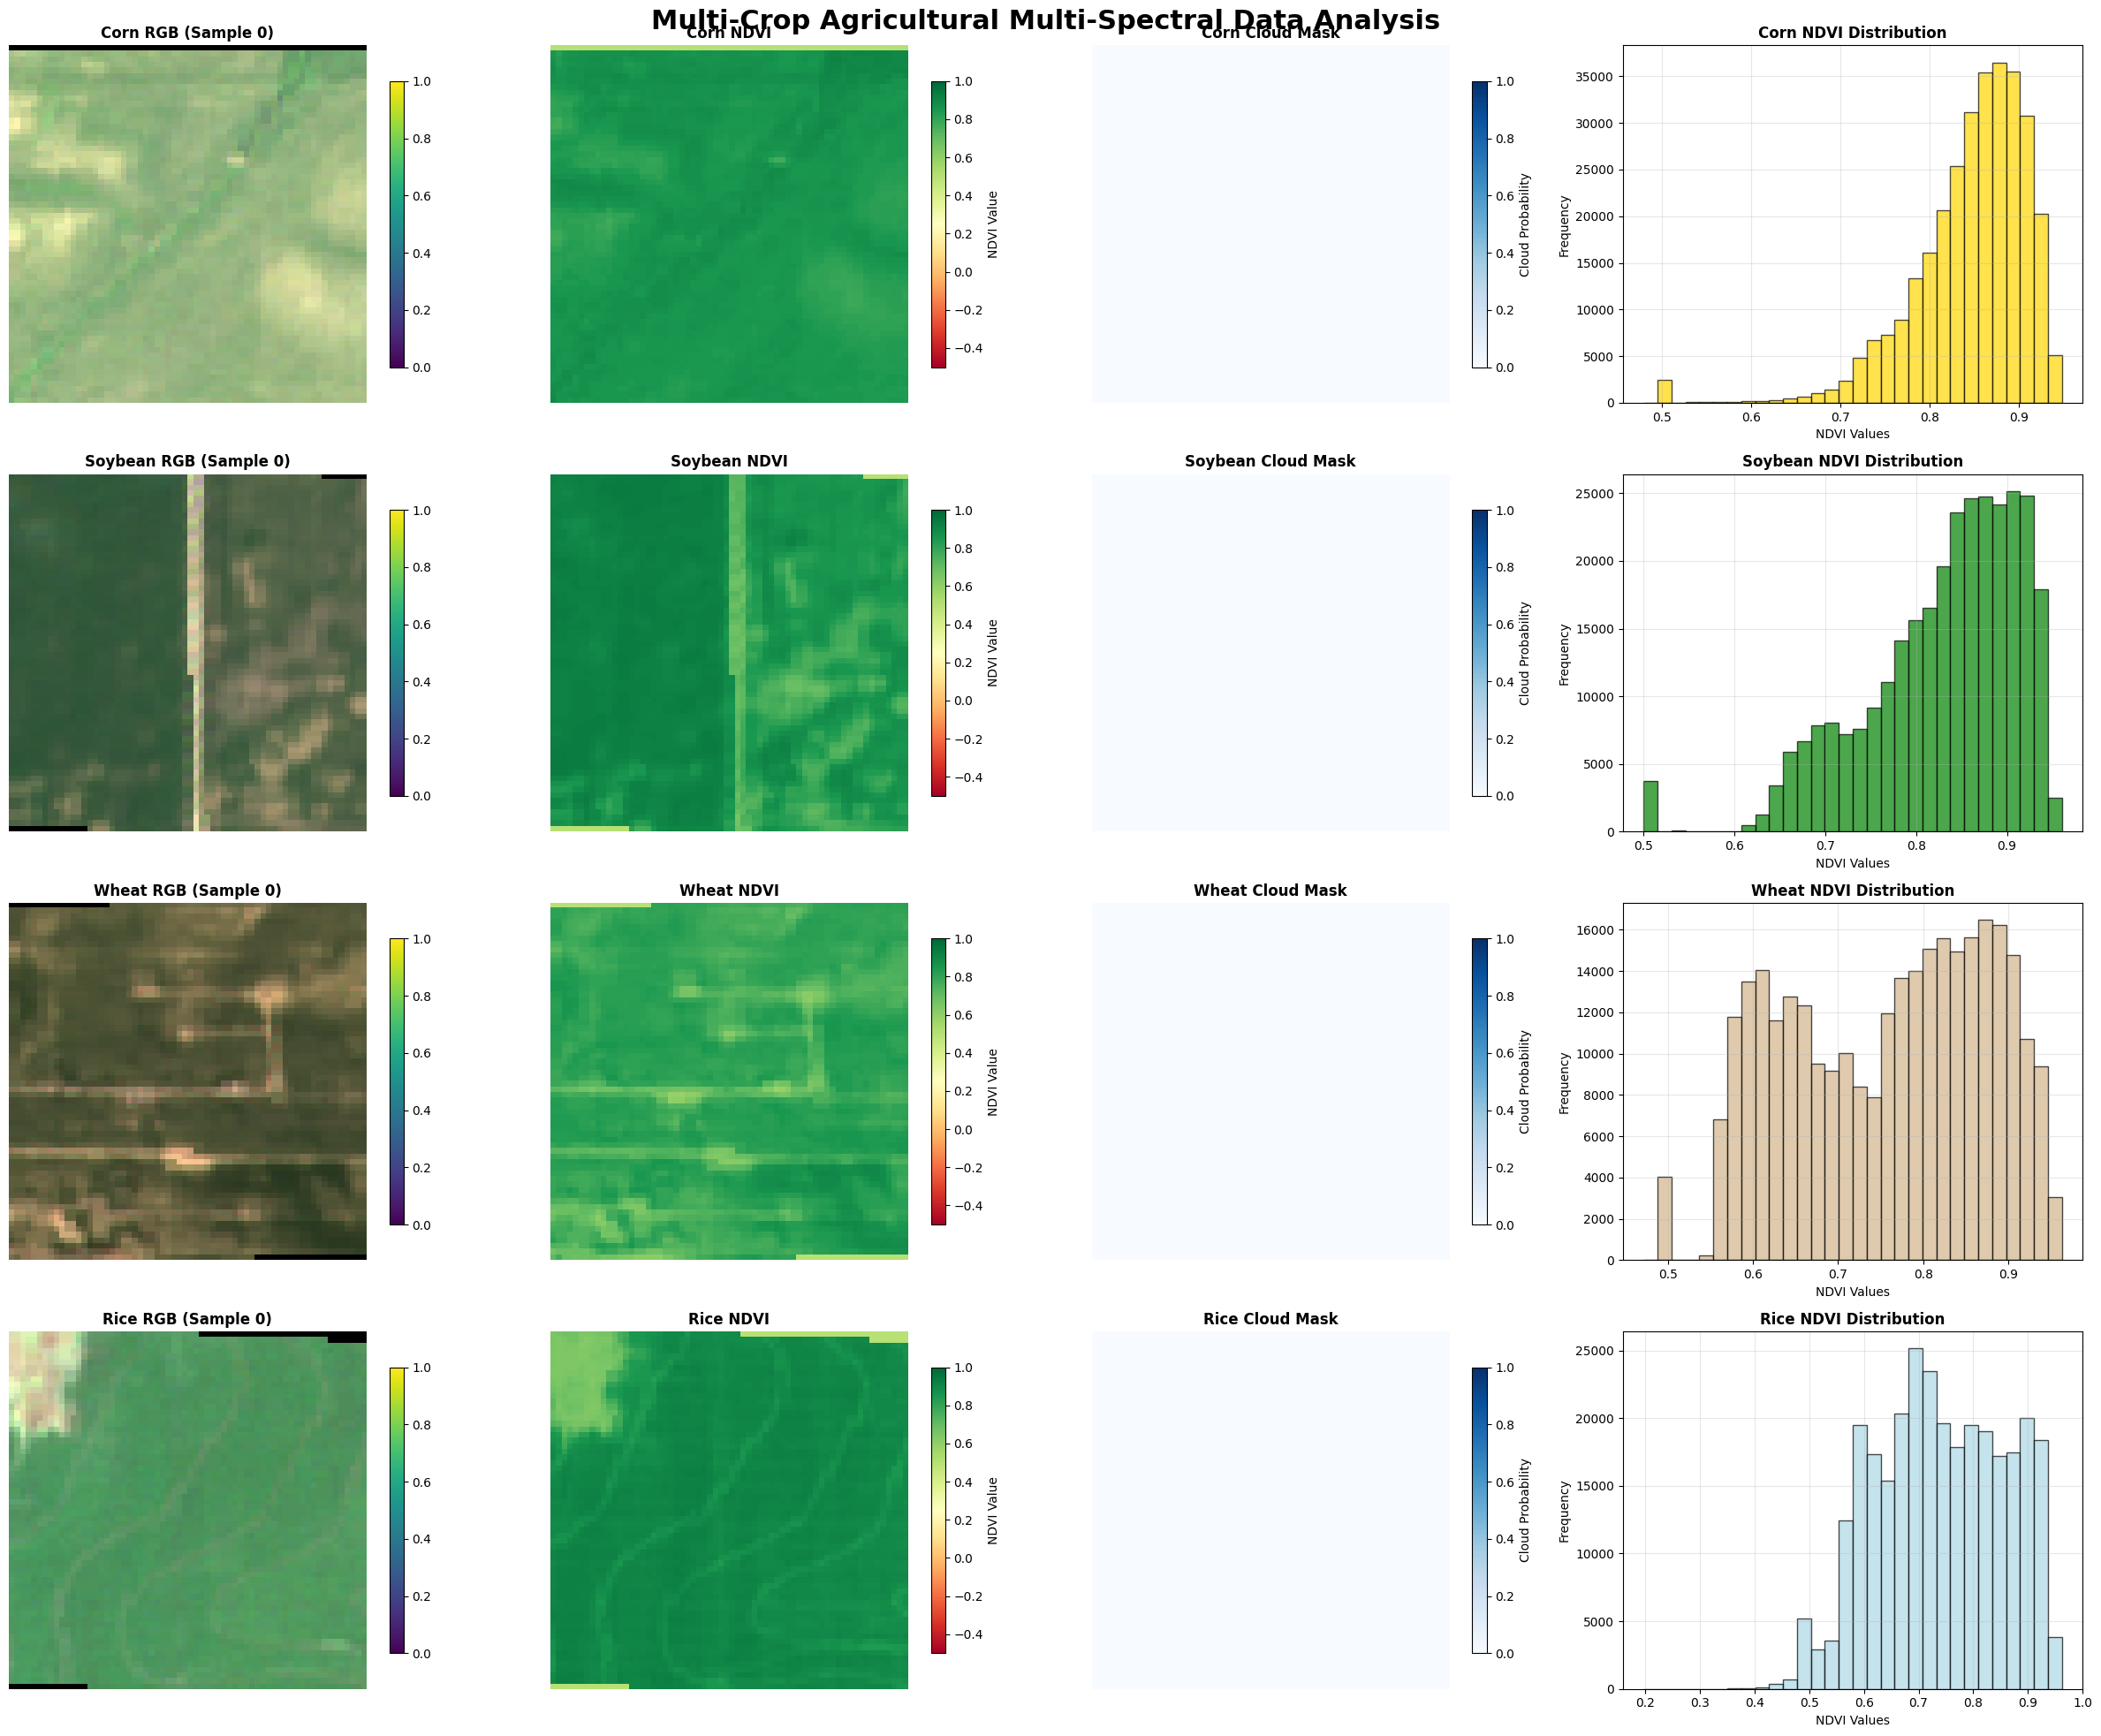


Creating cross-crop comparison dashboard...


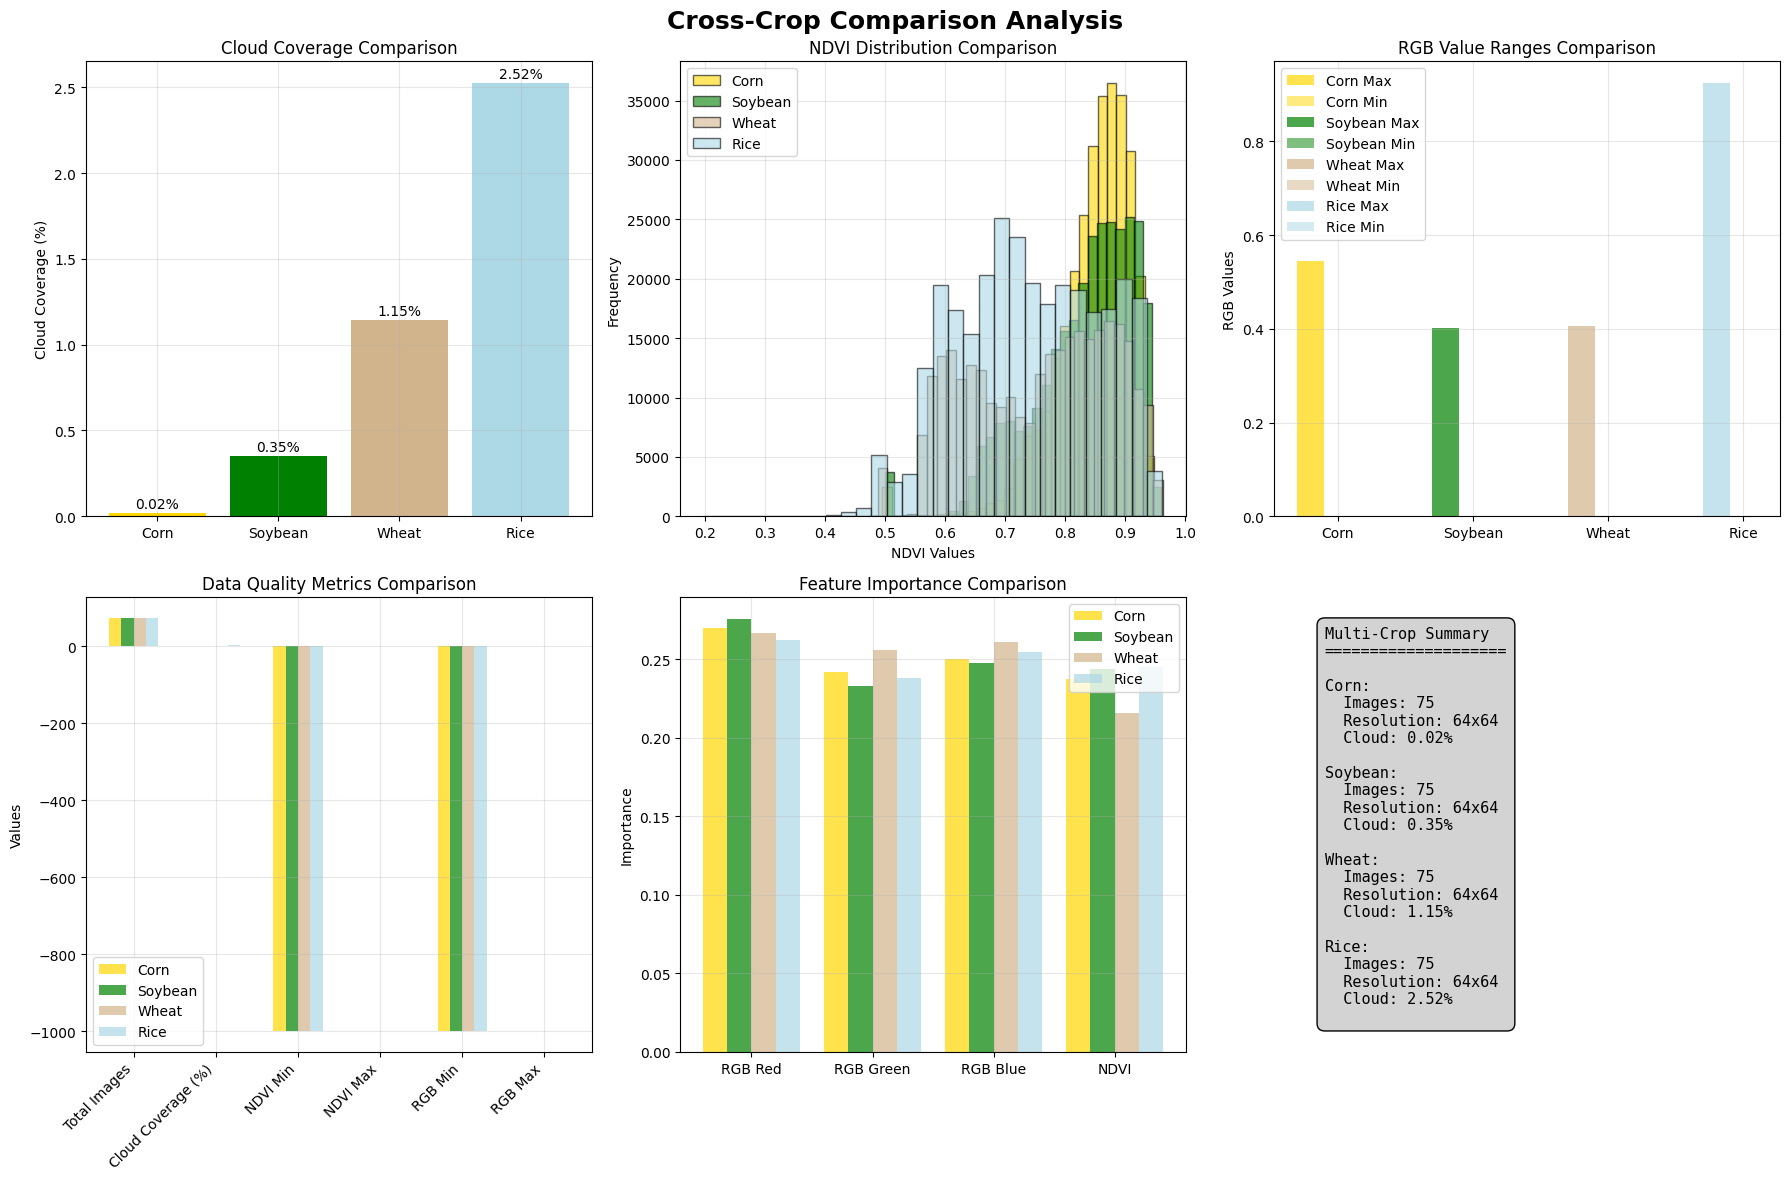

✓ Comprehensive multi-crop analysis dashboard created successfully!


In [58]:
# Create comprehensive multi-crop agricultural analysis dashboard
print("Creating comprehensive multi-crop agricultural analysis dashboard...")

# Create a large figure with multiple subplots
fig, axes = plt.subplots(4, 4, figsize=(24, 20))
fig.suptitle('Multi-Crop Agricultural Multi-Spectral Data Analysis', fontsize=22, fontweight='bold')

# Define crop colors for consistency
crop_colors = {'corn': 'gold', 'soybean': 'green', 'wheat': 'tan', 'rice': 'lightblue'}

# Row 1-4: Individual crop analysis (RGB, NDVI, Cloud Mask, NDVI Distribution)
for idx, (crop_name, dataset) in enumerate(crop_datasets.items()):
    row = idx
    
    # 1. RGB visualization for this crop
    rgb_sample = dataset['rgb'][0].transpose(1, 2, 0)
    rgb_normalized = np.clip((rgb_sample - rgb_sample.min()) / (rgb_sample.max() - rgb_sample.min()), 0, 1)
    im1 = axes[row, 0].imshow(rgb_normalized, cmap='viridis')
    axes[row, 0].set_title(f'{crop_name.capitalize()} RGB (Sample 0)', fontweight='bold', fontsize=12)
    axes[row, 0].axis('off')
    plt.colorbar(im1, ax=axes[row, 0], shrink=0.8)
    
    # 2. NDVI visualization for this crop
    ndvi_sample = dataset['ndvi'][0]
    ndvi_masked = np.ma.masked_where(ndvi_sample < -100, ndvi_sample)
    im2 = axes[row, 1].imshow(ndvi_masked, cmap='RdYlGn', vmin=-0.5, vmax=1.0)
    axes[row, 1].set_title(f'{crop_name.capitalize()} NDVI', fontweight='bold', fontsize=12)
    axes[row, 1].axis('off')
    cbar2 = plt.colorbar(im2, ax=axes[row, 1], shrink=0.8)
    cbar2.set_label('NDVI Value')
    
    # 3. Cloud mask for this crop
    cloud_sample = dataset['cloud_mask'][0]
    im3 = axes[row, 2].imshow(cloud_sample, cmap='Blues', vmin=0, vmax=1)
    axes[row, 2].set_title(f'{crop_name.capitalize()} Cloud Mask', fontweight='bold', fontsize=12)
    axes[row, 2].axis('off')
    cbar3 = plt.colorbar(im3, ax=axes[row, 2], shrink=0.8)
    cbar3.set_label('Cloud Probability')
    
    # 4. NDVI distribution for this crop
    ndvi_data = dataset['ndvi'].flatten()
    valid_ndvi = ndvi_data[ndvi_data > -100]
    axes[row, 3].hist(valid_ndvi, bins=30, alpha=0.7, color=crop_colors[crop_name], edgecolor='black')
    axes[row, 3].set_title(f'{crop_name.capitalize()} NDVI Distribution', fontweight='bold', fontsize=12)
    axes[row, 3].set_xlabel('NDVI Values')
    axes[row, 3].set_ylabel('Frequency')
    axes[row, 3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create comparison dashboard (no duplication)
print("\nCreating cross-crop comparison dashboard...")

fig2, axes2 = plt.subplots(2, 3, figsize=(18, 12))
fig2.suptitle('Cross-Crop Comparison Analysis', fontsize=18, fontweight='bold')

# 1. Cloud coverage comparison across crops
cloud_percentages = []
crop_labels = []
for crop_name, dataset in crop_datasets.items():
    cloud_percentages.append(np.mean(dataset['cloud_mask']) * 100)
    crop_labels.append(crop_name.capitalize())

bars = axes2[0, 0].bar(crop_labels, cloud_percentages, color=[crop_colors[crop] for crop in crop_datasets.keys()])
axes2[0, 0].set_title('Cloud Coverage Comparison')
axes2[0, 0].set_ylabel('Cloud Coverage (%)')
axes2[0, 0].grid(True, alpha=0.3)

# Add value labels on bars
for bar, percentage in zip(bars, cloud_percentages):
    height = bar.get_height()
    axes2[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                      f'{percentage:.2f}%', ha='center', va='bottom')

# 2. NDVI comparison across crops
for crop_name, dataset in crop_datasets.items():
    ndvi_data = dataset['ndvi'].flatten()
    valid_ndvi = ndvi_data[ndvi_data > -100]
    axes2[0, 1].hist(valid_ndvi, bins=30, alpha=0.6, label=crop_name.capitalize(), 
                      color=crop_colors[crop_name], edgecolor='black')
axes2[0, 1].set_title('NDVI Distribution Comparison')
axes2[0, 1].set_xlabel('NDVI Values')
axes2[0, 1].set_ylabel('Frequency')
axes2[0, 1].legend()
axes2[0, 1].grid(True, alpha=0.3)

# 3. RGB value ranges comparison
x_pos = np.arange(len(crop_labels))
width = 0.2

for i, (crop_name, dataset) in enumerate(crop_datasets.items()):
    rgb_data = dataset['rgb'].flatten()
    valid_rgb = rgb_data[rgb_data > -100]
    axes2[0, 2].bar(x_pos[i] - width, valid_rgb.max(), width, 
                     label=f'{crop_name.capitalize()} Max', color=crop_colors[crop_name], alpha=0.7)
    axes2[0, 2].bar(x_pos[i], valid_rgb.min(), width, 
                     label=f'{crop_name.capitalize()} Min', color=crop_colors[crop_name], alpha=0.5)

axes2[0, 2].set_title('RGB Value Ranges Comparison')
axes2[0, 2].set_ylabel('RGB Values')
axes2[0, 2].set_xticks(x_pos)
axes2[0, 2].set_xticklabels(crop_labels)
axes2[0, 2].legend()
axes2[0, 2].grid(True, alpha=0.3)

# 4. Data quality metrics comparison
quality_metrics = {}
for crop_name, dataset in crop_datasets.items():
    quality_metrics[crop_name] = {
        'Total Images': len(dataset['rgb']),
        'Cloud Coverage': np.mean(dataset['cloud_mask']) * 100,
        'NDVI Range': [np.min(dataset['ndvi']), np.max(dataset['ndvi'])],
        'RGB Range': [np.min(dataset['rgb']), np.max(dataset['rgb'])]
    }

metric_names = ['Total Images', 'Cloud Coverage (%)', 'NDVI Min', 'NDVI Max', 'RGB Min', 'RGB Max']
x_pos_metrics = np.arange(len(metric_names))

for i, crop_name in enumerate(crop_datasets.keys()):
    metrics = quality_metrics[crop_name]
    values = [metrics['Total Images'], metrics['Cloud Coverage'], 
              metrics['NDVI Range'][0], metrics['NDVI Range'][1],
              metrics['RGB Range'][0], metrics['RGB Range'][1]]
    
    axes2[1, 0].bar(x_pos_metrics + i*0.15, values, 0.15, 
                     label=crop_name.capitalize(), color=crop_colors[crop_name], alpha=0.7)

axes2[1, 0].set_title('Data Quality Metrics Comparison')
axes2[1, 0].set_ylabel('Values')
axes2[1, 0].set_xticks(x_pos_metrics + 0.225)
axes2[1, 0].set_xticklabels(metric_names, rotation=45, ha='right')
axes2[1, 0].legend()
axes2[1, 0].grid(True, alpha=0.3)

# 5. Feature importance comparison across crops
feature_importance_data = {}
for crop_name, dataset in crop_datasets.items():
    # Calculate feature importance for this crop
    rgb_variance = [np.var(dataset['rgb'][:, i, :, :]) for i in range(3)]
    ndvi_variance = np.var(dataset['ndvi'])
    
    # Calculate correlations
    rgb_ndvi_correlations = []
    for i in range(3):
        rgb_channel = dataset['rgb'][:, i, :, :].flatten()
        ndvi_flat = dataset['ndvi'].flatten()
        valid_mask = (rgb_channel > -100) & (ndvi_flat > -100)
        if np.sum(valid_mask) > 100:
            corr = np.corrcoef(rgb_channel[valid_mask], ndvi_flat[valid_mask])[0, 1]
            rgb_ndvi_correlations.append(abs(corr) if not np.isnan(corr) else 0)
        else:
            rgb_ndvi_correlations.append(0)
    
    # Calculate importance
    feature_importance = []
    for i in range(3):
        importance = (rgb_variance[i] * (1 + rgb_ndvi_correlations[i])) / sum(rgb_variance)
        feature_importance.append(importance)
    
    ndvi_importance = (ndvi_variance * 1.5) / sum(rgb_variance)
    feature_importance.append(ndvi_importance)
    
    # Normalize
    total_importance = sum(feature_importance)
    feature_importance = [imp / total_importance for imp in feature_importance]
    feature_importance_data[crop_name] = feature_importance

# Plot feature importance comparison
feature_names = ['RGB Red', 'RGB Green', 'RGB Blue', 'NDVI']
x_pos_features = np.arange(len(feature_names))

for i, crop_name in enumerate(crop_datasets.keys()):
    importance_values = feature_importance_data[crop_name]
    axes2[1, 1].bar(x_pos_features + i*0.2, importance_values, 0.2, 
                     label=crop_name.capitalize(), color=crop_colors[crop_name], alpha=0.7)

axes2[1, 1].set_title('Feature Importance Comparison')
axes2[1, 1].set_ylabel('Importance')
axes2[1, 1].set_xticks(x_pos_features + 0.3)
axes2[1, 1].set_xticklabels(feature_names)
axes2[1, 1].legend()
axes2[1, 1].grid(True, alpha=0.3)

# 6. Summary statistics
axes2[1, 2].axis('off')
summary_text = "Multi-Crop Summary\n"
summary_text += "=" * 20 + "\n"
for crop_name, dataset in crop_datasets.items():
    summary_text += f"\n{crop_name.capitalize()}:\n"
    summary_text += f"  Images: {dataset['rgb'].shape[0]}\n"
    summary_text += f"  Resolution: {dataset['rgb'].shape[2]}x{dataset['rgb'].shape[3]}\n"
    summary_text += f"  Cloud: {np.mean(dataset['cloud_mask'])*100:.2f}%\n"

axes2[1, 2].text(0.1, 0.5, summary_text, fontsize=11, fontfamily='monospace', 
                  verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray"))

plt.tight_layout()
plt.show()

print("✓ Comprehensive multi-crop analysis dashboard created successfully!")

## Part 5: Real-World Applications and Use Cases

## Business Impact Assessment

### Potential Precision Agriculture Applications

**Crop Health Monitoring**
- NDVI-based health assessment (healthy: >0.6, stressed: 0.3-0.6, critical: <0.3)
- **Note:** NDVI values can be affected by shadows, cloud cover, and atmospheric conditions
- Automated stress detection and intervention recommendations

**Resource Optimization**
- Zone-based irrigation targeting based on vegetation density
- Data-driven fertilizer application timing
- Precision application reduces waste

**Operational Benefits**
- Real-time field monitoring and alerts
- Automated quality assurance with cloud masking
- Multi-spectral validation for reliable analysis

**Economic Impact**
- Yield improvement through targeted interventions
- Reduced manual inspection labor
- Early stress detection prevents yield loss

In [62]:
# Demonstrate Real-World Agricultural ML Applications
print("Demonstrating Real-World Agricultural ML Applications...")

# Enhanced Agricultural Analysis with Multi-Crop Support
print("\n" + "="*60)
print("COMPREHENSIVE AGRICULTURAL ANALYSIS DASHBOARD")
print("="*60)

# Agricultural thresholds and parameters
agricultural_thresholds = {
    'healthy_ndvi': 0.6,
    'stressed_ndvi': 0.3,
    'critical_ndvi': 0.1,
    'high_vegetation': 0.7,
    'moderate_vegetation': 0.4,
    'low_vegetation': 0.2
}

# Multi-crop analysis results
crop_analysis_results = {}

for crop_name, dataset in crop_datasets.items():
    print(f"\n{crop_name.upper()} ANALYSIS:")
    print("-" * 40)
    
    # Calculate comprehensive agricultural metrics
    ndvi_data = dataset['ndvi'].flatten()
    valid_ndvi = ndvi_data[ndvi_data > -100]  # Filter out masked values
    
    # Crop health assessment
    healthy_pixels = np.sum(valid_ndvi > agricultural_thresholds['healthy_ndvi'])
    stressed_pixels = np.sum((valid_ndvi > agricultural_thresholds['stressed_ndvi']) & 
                            (valid_ndvi <= agricultural_thresholds['healthy_ndvi']))
    critical_pixels = np.sum(valid_ndvi <= agricultural_thresholds['stressed_ndvi'])
    total_valid_pixels = len(valid_ndvi)
    
    # Vegetation density analysis
    high_veg_pixels = np.sum(valid_ndvi > agricultural_thresholds['high_vegetation'])
    moderate_veg_pixels = np.sum((valid_ndvi > agricultural_thresholds['moderate_vegetation']) & 
                                (valid_ndvi <= agricultural_thresholds['high_vegetation']))
    low_veg_pixels = np.sum(valid_ndvi <= agricultural_thresholds['moderate_vegetation'])
    
    # Calculate agricultural indices
    mean_ndvi = np.mean(valid_ndvi)
    ndvi_std = np.std(valid_ndvi)
    ndvi_cv = ndvi_std / mean_ndvi if mean_ndvi > 0 else 0  # Coefficient of variation
    
    # Store results
    crop_analysis_results[crop_name] = {
        'health_metrics': {
            'healthy_pixels': healthy_pixels,
            'stressed_pixels': stressed_pixels,
            'critical_pixels': critical_pixels,
            'total_pixels': total_valid_pixels
        },
        'vegetation_density': {
            'high_veg_pixels': high_veg_pixels,
            'moderate_veg_pixels': moderate_veg_pixels,
            'low_veg_pixels': low_veg_pixels
        },
        'statistical_metrics': {
            'mean_ndvi': mean_ndvi,
            'ndvi_std': ndvi_std,
            'ndvi_cv': ndvi_cv
        }
    }
    
    # Display results
    print(f"  Crop Health Assessment:")
    print(f"    Healthy crops (>0.6 NDVI): {healthy_pixels:,} pixels ({healthy_pixels/total_valid_pixels*100:.1f}%)")
    print(f"    Stressed crops (0.3-0.6 NDVI): {stressed_pixels:,} pixels ({stressed_pixels/total_valid_pixels*100:.1f}%)")
    print(f"    Critical crops (<0.3 NDVI): {critical_pixels:,} pixels ({critical_pixels/total_valid_pixels*100:.1f}%)")
    
    print(f"  Vegetation Density:")
    print(f"    High vegetation (>0.7): {high_veg_pixels:,} pixels ({high_veg_pixels/total_valid_pixels*100:.1f}%)")
    print(f"    Moderate vegetation (0.4-0.7): {moderate_veg_pixels:,} pixels ({moderate_veg_pixels/total_valid_pixels*100:.1f}%)")
    print(f"    Low vegetation (<0.4): {low_veg_pixels:,} pixels ({low_veg_pixels/total_valid_pixels*100:.1f}%)")
    
    print(f"  Statistical Metrics:")
    print(f"    Mean NDVI: {mean_ndvi:.4f}")
    print(f"    NDVI Standard Deviation: {ndvi_std:.4f}")
    print(f"    Coefficient of Variation: {ndvi_cv:.4f}")

# Cross-crop comparison and insights
print(f"\n" + "="*60)
print("CROSS-CROP COMPARISON & INSIGHTS")
print("="*60)

# Health ranking
health_scores = {}
for crop_name, results in crop_analysis_results.items():
    health_ratio = results['health_metrics']['healthy_pixels'] / results['health_metrics']['total_pixels']
    health_scores[crop_name] = health_ratio

print(f"\nCrop Health Ranking (Healthiest to Most Stressed):")
for crop, score in sorted(health_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"  {crop.capitalize()}: {score*100:.1f}% healthy")

# Vegetation density comparison
print(f"\nVegetation Density Comparison:")
for crop_name, results in crop_analysis_results.items():
    high_veg_ratio = results['vegetation_density']['high_veg_pixels'] / results['health_metrics']['total_pixels']
    print(f"  {crop_name.capitalize()}: {high_veg_ratio*100:.1f}% high vegetation")

# Agricultural recommendations
print(f"\n" + "="*60)
print("AGRICULTURAL RECOMMENDATIONS")
print("="*60)

for crop_name, results in crop_analysis_results.items():
    print(f"\n{crop_name.upper()} RECOMMENDATIONS:")
    print("-" * 30)
    
    health_ratio = results['health_metrics']['healthy_pixels'] / results['health_metrics']['total_pixels']
    critical_ratio = results['health_metrics']['critical_pixels'] / results['health_metrics']['total_pixels']
    
    if health_ratio > 0.7:
        print(f"  ✓ Excellent crop health - maintain current practices")
        print(f"  ✓ Consider precision harvesting optimization")
    elif health_ratio > 0.5:
        print(f"  ⚠ Moderate crop health - monitor closely")
        print(f"  ✓ Implement targeted irrigation if needed")
    else:
        print(f"  ⚠ Poor crop health - immediate attention required")
        print(f"  ✓ Investigate soil conditions and irrigation")
    
    if critical_ratio > 0.2:
        print(f"  ⚠ High stress areas detected - consider intervention")
        print(f"  ✓ Evaluate fertilizer application timing")
    
    # Resource optimization
    mean_ndvi = results['statistical_metrics']['mean_ndvi']
    if mean_ndvi < 0.4:
        print(f" Low vegetation suggests irrigation optimization needed")
    elif mean_ndvi > 0.6:
        print(f" Strong vegetation - optimal resource utilization")

Demonstrating Real-World Agricultural ML Applications...

COMPREHENSIVE AGRICULTURAL ANALYSIS DASHBOARD

CORN ANALYSIS:
----------------------------------------
  Crop Health Assessment:
    Healthy crops (>0.6 NDVI): 304,113 pixels (99.0%)
    Stressed crops (0.3-0.6 NDVI): 3,023 pixels (1.0%)
    Critical crops (<0.3 NDVI): 0 pixels (0.0%)
  Vegetation Density:
    High vegetation (>0.7): 299,831 pixels (97.6%)
    Moderate vegetation (0.4-0.7): 7,305 pixels (2.4%)
    Low vegetation (<0.4): 0 pixels (0.0%)
  Statistical Metrics:
    Mean NDVI: 0.8463
    NDVI Standard Deviation: 0.0653
    Coefficient of Variation: 0.0772

SOYBEAN ANALYSIS:
----------------------------------------
  Crop Health Assessment:
    Healthy crops (>0.6 NDVI): 302,201 pixels (98.7%)
    Stressed crops (0.3-0.6 NDVI): 3,911 pixels (1.3%)
    Critical crops (<0.3 NDVI): 0 pixels (0.0%)
  Vegetation Density:
    High vegetation (>0.7): 276,275 pixels (90.3%)
    Moderate vegetation (0.4-0.7): 29,837 pixels (9

## Conclusion and Next Steps

This notebook has demonstrated **data analysis practices that support agricultural ML**, across the same five pillars introduced at the start:

- **Multi-spectral Data Handling** – NDVI and multi-band imagery workflows  
- **Data Quality & Validation** – Automated checks, thresholds, and QA methods  
- **Analysis Workflows** – Systematic processes for multi-crop datasets  
- **Visualization & Reporting** – Actionable insights communicated clearly  
- **Domain Relevance** – Practical use cases in crop health and precision farming  

### Applications

These analysis methods enable:

- Simple NDVI-based crop health assessment  
- Data pipelines that feed monitoring and alert systems  
- Validation datasets for developing ML health scoring algorithms  
- Structured comparisons across crops and regions  

### Next Steps

1. **Implement cloud masking** – Add atmospheric correction and cloud detection methods  
2. **Expand coverage** – Support additional crops and region-specific thresholds  
3. **Introduce temporal analysis** – Apply time-series methods for crop growth tracking  

---

By establishing strong foundations in **data preparation, validation, and exploratory analysis**, this notebook demonstrates how agricultural datasets can be transformed into high-quality inputs for machine learning and decision-making.